In [2]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import model_crommelin_seasonal
import feature_crommelin 
from importlib import reload
import sys 
import os
from os import mkdir, makedirs
from os.path import join,exists
from importlib import reload
import pickle

In [3]:
import matplotlib.pyplot as plt 
%matplotlib inline

Create directories to save results 

In [4]:
# Organize the directory of data and features to be read from the data. 
topic_dir = "/scratch/jf4241/crommelin"
filedict = dict({
    "ra": dict({
        "traj": dict({
            "dir": join(topic_dir, "reanalysis", "trajectory", "2022-07-26", "0"), # Directory with possibly many files
        }),
        "feat_all": dict({
            "dir": join(topic_dir, "reanalysis", "features_all", "2022-07-26", "0"),
            "filename": "crom_feat_all.nc",
        }),
        "feat_tpt": dict({
            "dir": join(topic_dir, "reanalysis", "features_tpt", "2022-07-26", "0",),
            "filename": "crom_feat_tpt.nc",
        }),
    }),
    "hc": dict({
        "traj": dict({
            "dir": join(topic_dir, "hindcast", "trajectory", "2022-07-26", "0"), # Directory with possibly multiple files
        }),
        "feat_all": dict({
            "dir": join(topic_dir, "hindcast", "features_all", "2022-07-26", "0"),
            "filename": "crom_feat_all.nc",
        }),
        "feat_tpt": dict({
            "dir": join(topic_dir, "hindcast", "features_tpt", "2022-07-26", "0"),
            "filename": "crom_feat_tpt.nc",
        })
    }),
    "results": dict({
        "dir": join(topic_dir, "results", "2022-07-26", "0")
    })
})

In [5]:
# Create the directories if they don't exist already
for src in ["ra","hc"]:
    for fmt in ["traj","feat_all","feat_tpt"]:
        path = filedict[src][fmt]["dir"]
        if not exists(path):
            makedirs(path, exist_ok=True)
path = filedict["results"]["dir"]
if not exists(path): makedirs(path, exist_ok=True)

Set physical parameters

In [6]:
dt_samp = 0.5 # Time step to save out
dt_szn = 0.74 # Time resolution for the seasonal model 
szn_start = 300.0
szn_length = 250.0
year_length = 400.0
Nt_szn = int(szn_length / dt_szn)
szn_avg_window = 5.0
burnin_time = 500.0

In [7]:
reload(model_crommelin_seasonal)

<module 'model_crommelin_seasonal' from '/home/jf4241/ecmwf/tpt_ecmwf/demo/model_crommelin_seasonal.py'>

Initialize the model.

In [8]:
fundamental_param_dict = dict({
    "b": 0.5, "beta": 1.25, "gamma_limits": [0.15, 0.22], 
    "C": 0.1, "x1star": 0.95, "r": -0.801, "year_length": year_length,
})
crom = model_crommelin_seasonal.SeasonalCrommelinModel(fundamental_param_dict)


Create "reanalysis" in the file folder reserved for contiguous data.

In [9]:
# Run the model initially for a bit to find the attractor. Start arbitrarily 1/5 of the way through year 1958
t_init = (1957 + 0.2)*fundamental_param_dict["year_length"]
x0 = np.zeros((1,7))
x0[0,-1] = t_init
t_save = np.arange(0, burnin_time, dt_samp)
traj_filename_burnin = join(filedict["ra"]["traj"]["dir"], "burnin.nc")
crom.integrate_and_save(x0,t_save,traj_filename_burnin)

In [10]:
x_burnin = xr.open_dataset(traj_filename_burnin)["X"]
x0 = x_burnin[:,-1].data
duration = 20*fundamental_param_dict["year_length"]
t_init_str,_ = crom.date_format(x0[0,-1])
t_fin_str,_ = crom.date_format(x0[0,-1] + duration)
traj_filename_ra = join(filedict["ra"]["traj"]["dir"], f"ra_{t_init_str}_to_{t_fin_str}.nc")
param_filename_ra = join(filedict["ra"]["traj"]["dir"], "params")

In [52]:
t_save = np.arange(0,duration,dt_samp)
crom.integrate_and_save(x0,t_save,traj_filename_ra,metadata_filename=param_filename_ra)

Integrated through time 1000.0000000001588 out of 7999.5
Integrated through time 2000.0999999992764 out of 7999.5
Integrated through time 3000.099999998367 out of 7999.5
Integrated through time 4000.0999999974574 out of 7999.5
Integrated through time 5000.0000000006585 out of 7999.5
Integrated through time 6000.000000004296 out of 7999.5
Integrated through time 7000.000000007934 out of 7999.5


Create "hindcast" data in the file folder reserved for hindcast data.

In [ ]:
# Generate hindcast dataset
t_abs_range = crom.q["year_length"]*np.array([1960,1970])
crom.generate_hindcast_dataset(
    [traj_filename_ra],filedict["hc"]["traj"]["dir"],t_abs_range,dt_samp,
    ens_size=10,ens_duration=47,ens_gap=13,pert_scale=0.01
)

Extract features of interest from both the reanalysis and hindcast datasets. This will be expensive, as we have to read from a large database of files. Therefore, we should minimize the number of times we do this in development. Therefore, we should read in ALL possible features we MIGHT use for the downstream tasks of K-means clustering. Some extra reduction is likely necessary.

# All possible features for DGA

In [11]:
reload(feature_crommelin)

<module 'feature_crommelin' from '/home/jf4241/ecmwf/tpt_ecmwf/demo/feature_crommelin.py'>

In [12]:
# Extract all features of potential use from the reanalysis dataset. 
# Don't waste RAM by time-delay embedding explicitly
# Encode this in a function that loops through all files in a directory and puts features into one file
crom_feat = feature_crommelin.SeasonalCrommelinModelFeatures()
qra = pickle.load(open(param_filename_ra,"rb"))

In [13]:
epd = dict(
    dt_szn = 0.74,
    szn_start = 300.0,
    szn_length = 250.0,
    year_length = 400.0,
    szn_avg_window = 5.0,
)
epd["Nt_szn"] = int(epd["szn_length"] / epd["dt_szn"])
crom_feat.set_event_params(epd)

In [14]:
# WARNING! So that this steps work, the 'feature' coordinate of each observable must be uniquely named. 
# For example, if the identity observable and energy observable both have a coordinate called "feature", 
# then xarray will assume it's the same and smush them together, filling in NaNs. x
feat_all = dict()

In [59]:
for src in ["ra","hc"]:
    ds_feature_list = []
    file_list = [f for f in os.listdir(filedict[src]["traj"]["dir"]) if (f.startswith(src) and f.endswith(".nc"))]
    for filename in file_list:
        ds = xr.open_dataset(join(filedict[src]["traj"]["dir"], filename))
        ds_feature_list += [
            xr.Dataset(
                data_vars = dict({
                    "identity": crom_feat.identity_observable(ds, qra),
                    "energy": crom_feat.energy_observable(ds, qra),
                    "energy_tendency": crom_feat.energy_tendency_observable(ds, qra),
                    "energy_exchange": crom_feat.energy_exchange_observable(ds, qra),
                    "phase": crom_feat.phase_observable(ds, qra),
                })
            )
        ]
        ds.close()
    feat_all[src] = xr.concat(ds_feature_list,dim="ensemble") # ensemble is a new dimension
    feat_all[src].to_netcdf(join(filedict[src]["feat_all"]["dir"], filedict[src]["feat_all"]["filename"]))

# Subset observables for use in TPT analysis
Incorporate any time-delay information we might want. 

In [15]:
feat_all = dict()
feat_tpt = dict()
# List the features to put into feat_tpt
# First, the features needed to define A and B: the time, the x1 coordinate, and its running mean, min, and max
# over some time horizon. 
time_horizon = 40.0 # time units
feat_tpt_list = ["t_abs","x1","x1_runmean","x1_runmin","x1_runmax","t_szn","szn_start_year","t_cal","ti_szn"]
# Physical features
feat_tpt_list += ["E_01","E_02","E_11","E_12","E_tot","Edot_dissipation","Edot_forcing"]
for src in ["ra","hc"]:
    feat_all[src] = xr.open_dataset(join(filedict[src]["feat_all"]["dir"], filedict[src]["feat_all"]["filename"]))
    feat_tpt[src] = xr.Dataset(
        data_vars = {
            "X": xr.DataArray(               
                coords = {
                    "ensemble": feat_all[src].coords["ensemble"],
                    "member": feat_all[src].coords["member"],
                    "t_sim": feat_all[src].coords["t_sim"],
                    "feature": feat_tpt_list,
                },
                data = np.zeros((
                    feat_all[src]["ensemble"].size, feat_all[src]["member"].size, 
                    feat_all[src]["t_sim"].size, len(feat_tpt_list)
                )),
            )
        }
    )
    feat_tpt[src]["X"].loc[dict(feature="t_abs")] = feat_all[src]["identity"].sel(feature="t_abs")
    feat_tpt[src]["X"].loc[dict(feature="E_01")] = feat_all[src]["energy"].sel(reservoir="E01")
    feat_tpt[src]["X"].loc[dict(feature="E_02")] = feat_all[src]["energy"].sel(reservoir="E02")
    feat_tpt[src]["X"].loc[dict(feature="E_11")] = feat_all[src]["energy"].sel(reservoir="E11")
    feat_tpt[src]["X"].loc[dict(feature="E_12")] = feat_all[src]["energy"].sel(reservoir="E12")
    feat_tpt[src]["X"].loc[dict(feature="E_tot")] = feat_all[src]["energy"].sel(reservoir="Etot")
    feat_tpt[src]["X"].loc[dict(feature="Edot_dissipation")] = feat_all[src]["energy_tendency"].sel(Eflow="dissipation")
    feat_tpt[src]["X"].loc[dict(feature="Edot_forcing")] = feat_all[src]["energy_tendency"].sel(Eflow="forcing")
    # For the A- and B-defining feature of x1, take the running mean, minimum, and maximum of x1 over the time horizon
    feat_tpt[src]["X"].loc[dict(feature="x1")] = feat_all[src]["identity"].sel(feature="x1")
    dt_samp = (feat_all[src]["t_sim"][1] - feat_all[src]["t_sim"][0]).data # Assume uniform time sampling!
    num_delays = int(time_horizon/dt_samp) + 1
    rolling_x1 = feat_all[src]["identity"].sel(feature="x1").rolling(
        dim={"t_sim": num_delays}, min_periods=num_delays) 
    feat_tpt[src]["X"].loc[dict(feature="x1_runmean")] = rolling_x1.mean() 
    feat_tpt[src]["X"].loc[dict(feature="x1_runmin")] = rolling_x1.min() 
    feat_tpt[src]["X"].loc[dict(feature="x1_runmax")] = rolling_x1.max() 
    # Compute the calendar time and other temporal metadata, as this defines the seasonality 
    szn_start_year,t_cal,t_szn,ti_szn = crom_feat.time_conversion_from_absolute(
        feat_all[src]["identity"].sel(feature="t_abs")
    )
    feat_tpt[src]["X"].loc[dict(feature="t_szn")] = t_szn # Time since the most recent season beginning
    feat_tpt[src]["X"].loc[dict(feature="szn_start_year")] = szn_start_year
    feat_tpt[src]["X"].loc[dict(feature="t_cal")] = t_cal
    feat_tpt[src]["X"].loc[dict(feature="ti_szn")] = ti_szn # Which window of the discretized season this sample belongs to
    # Save 
    feat_tpt[src].to_netcdf(join(filedict[src]["feat_tpt"]["dir"], filedict[src]["feat_tpt"]["filename"]))

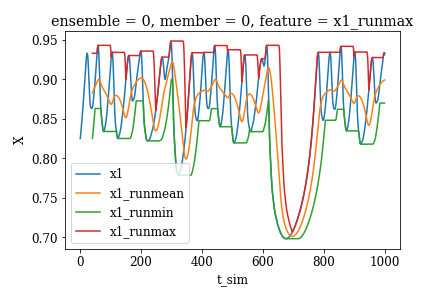

In [16]:
# Plot the running mean, min, and max of x1
fig,ax = plt.subplots()
h_x1, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(feature="x1",ensemble=0,member=0,t_sim=slice(None,1000)), ax=ax, label="x1"
)
h_x1_runmean, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(feature="x1_runmean",ensemble=0,member=0,t_sim=slice(None,1000)), ax=ax, label="x1_runmean"
)
h_x1_runmin, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(feature="x1_runmin",ensemble=0,member=0,t_sim=slice(None,1000)), ax=ax, label="x1_runmin"
)
h_x1_runmax, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(feature="x1_runmax",ensemble=0,member=0,t_sim=slice(None,1000)), ax=ax, label="x1_runmax"
)
ax.legend(handles=[h_x1,h_x1_runmean,h_x1_runmin,h_x1_runmax])

# Define A and B
Define a parameterized family of A and B, in this case a sequence of thresholds for x1_runmin and x1_runmax over a single time horizon. To vary the time horizon instead, we would have to enlarge the state space above to include information at a sequence of time delays.

In [17]:
abcode = {"A": 0, "B": 1, "D": 2}
def abtest(Xtpt, tpt_bndy):
    # Given a snapshot of an instance of the feat_tpt data structure, return ab_tag: 
    # 0 means in A, 1 means in B, and 2 means neither.
    # The definition of A and B will be parameterized by a dictionary, tpt_bndy, which specifies
    # the time of season when blockings can happen as well as the thresholds for A and B. 
    time_window_flag = 1.0*(
        Xtpt.sel(feature="t_szn") >= tpt_bndy["tthresh"][0])*(
        Xtpt.sel(feature="t_szn") <= tpt_bndy["tthresh"][1]
    )
    blocked_flag = 1.0*(Xtpt.sel(feature="x1_runmax") <= tpt_bndy["x1thresh"][0])
    zonal_flag = 1.0*(Xtpt.sel(feature="x1") >= tpt_bndy["x1thresh"][1])
    ab_tag = (
        abcode["A"]*((time_window_flag == 0) + zonal_flag > 0) + 
        abcode["B"]*(time_window_flag*blocked_flag) + 
        abcode["D"]*(time_window_flag*(blocked_flag==0)*(zonal_flag==0))
    )
    return ab_tag

In [18]:
tpt_bndy = {"tthresh": [10,200], "x1thresh": [0.8, 2.0]}
ab_tag = dict()
for src in ["ra","hc"]:
    ab_tag[src] = abtest(feat_tpt[src]["X"], tpt_bndy)

## Plot x1 over time, marked by whether in A, B, or neither

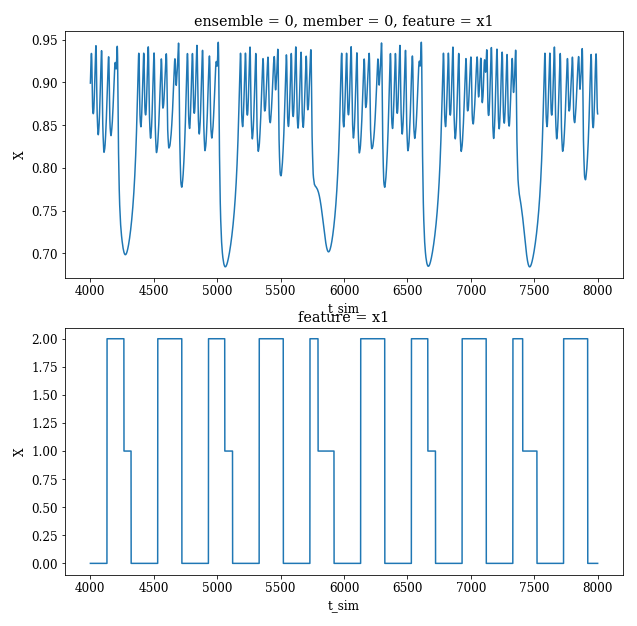

In [19]:
fig,ax = plt.subplots(nrows=2,figsize=(10,10))
selection = {"t_sim": slice(4000,10000), "ensemble": 0, "member": 0}
xr.plot.plot(
    feat_tpt["ra"]["X"].sel(selection).sel(feature="x1"),
    ax=ax[0]
)
xr.plot.plot(
    ab_tag["ra"].sel(selection,drop=True), ax=ax[1]
)


# Find and plot the committor, lead time, and current from reanalysis

In [20]:
# Function to find the time since and until hitting A and B
def cotton_eye_joe(Xtpt, tpt_bndy, ab_tag):
    sintil = xr.DataArray(
        coords = dict({
            "ensemble": Xtpt.coords["ensemble"],
            "member": Xtpt.coords["member"],
            "t_sim": Xtpt.coords["t_sim"],
            "sense": ["since","until"],
            "state": ["A","B"]
        }),
        data = np.nan*np.ones((Xtpt["ensemble"].size, Xtpt["member"].size, Xtpt["t_sim"].size, 2, 2)),
        dims = ["ensemble","member","t_sim","sense","state"],
    )
    # Forward pass through time 
    for i_time in np.arange(sintil["t_sim"].size):    
        if i_time % 200 == 0:
            print(f"Forward pass: through time {i_time} out of {sintil['t_sim'].size}")
        for state in ["A","B"]:            
            if i_time > 0:
                sintil[dict(t_sim=i_time)].loc[dict(sense="since")] = (
                    sintil.isel(t_sim=i_time-1).sel(sense="since").data + 
                    sintil["t_sim"][i_time].data - sintil["t_sim"][i_time-1].data
                )
            state_flag = (ab_tag.isel(t_sim=i_time) == abcode[state])
            # Wherever the state is achieved at this time slice, set the time since to zero
            sintil[dict(t_sim=i_time)].loc[dict(sense="since",state=state)] = (
                (xr.zeros_like(sintil.isel(t_sim=i_time).sel(sense="since",state=state))).where(
                state_flag, sintil.isel(t_sim=i_time).sel(sense="since",state=state))
            )
    # Backward pass through time
    for i_time in np.arange(sintil["t_sim"].size-1,-1,-1):
        if i_time % 200 == 0:
            print(f"Backward pass: through time {i_time} out of {sintil['t_sim'].size}")
        for state in ["A","B"]:
            if i_time < sintil["t_sim"].size-1:
                sintil[dict(t_sim=i_time)].loc[dict(sense="until")] = (
                    sintil.isel(t_sim=i_time+1).sel(sense="until").data + 
                    sintil["t_sim"][i_time+1].data - sintil["t_sim"][i_time].data
                )
            state_flag = (ab_tag.isel(t_sim=i_time) == abcode[state])
            sintil[dict(t_sim=i_time)].loc[dict(sense="until",state=state)] = (
                (xr.zeros_like(sintil.isel(t_sim=i_time).sel(sense="until",state=state))).where(
                state_flag, sintil.isel(t_sim=i_time).sel(sense="until",state=state))
            )
    return sintil   

In [ ]:
sintil = dict()
for src in ["hc","ra"]:
    sintil[src] = cotton_eye_joe(feat_tpt[src]["X"],tpt_bndy,ab_tag[src])

In [45]:
!ls {filedict["ra"]["traj"]["dir"]}

burnin.nc  params  ra_1958-179_to_1978-179.nc  sintil


In [43]:
for src in ["ra","hc"]:
    sintil[src].to_netcdf(join(filedict[src]["traj"]["dir"], "sintil"))

Reload the sintil object, and then plot committor and MFPTs in various coordinates. 

In [21]:
sintil = dict()
for src in ["hc","ra"]:
    sintil[src] = xr.open_dataarray(join(filedict[src]["traj"]["dir"], "sintil"))

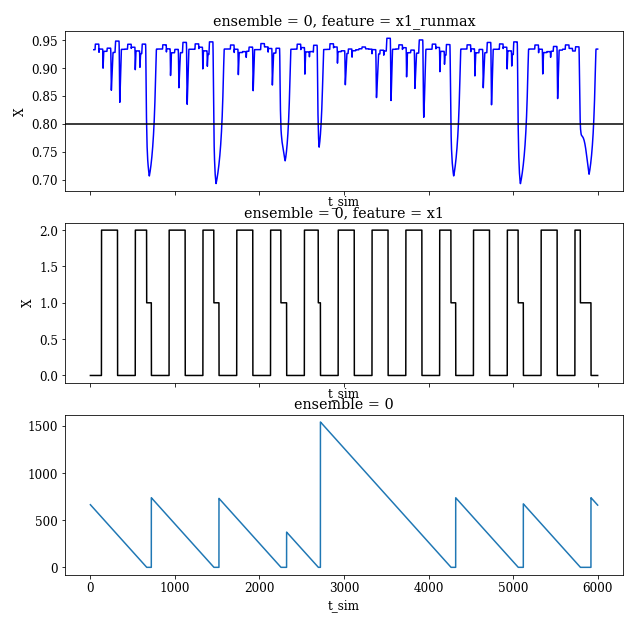

In [29]:
fig,axes = plt.subplots(nrows=3, figsize=(10,10), sharex=True)
sel = dict(member=0, t_sim=slice(None,6000))
h_x1, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="x1_runmax"),
    color="blue",ax=axes[0],label="$x_1$ running max")
axes[0].axhline(y=tpt_bndy["x1thresh"][0], color='black')
h_abtag = xr.plot.plot(
    ab_tag["ra"].sel(sel,drop=True),
    color="black", ax=axes[1], label="AB code"
)
h_tbp, = xr.plot.plot(
    sintil["ra"].sel(sel,drop=True).sel(state="B", sense="until", drop=True),
    ax=axes[2], label="$\tau_B^+$")

In [81]:
feat_tpt["hc"]["X"].shape, feat_tpt["ra"]["X"].shape

((297, 10, 94, 16), (1, 1, 16000, 16))

In [38]:
data_vars_clim = dict()
t_dim = np.where(np.array(feat_all["hc"].dims) == 't_sim')[0][0]
for obs_name in list(feat_all["hc"].data_vars.keys()):
    shp = list(feat_all["hc"][obs_name].shape)
    shp[t_dim] = crom_feat.Nt_szn
    data_vars_clim[obs_name] = np.zeros(shp)

In [ ]:
for obs_name in list(feat_all["hc"].data_vars.keys()):
    

In [15]:
feat_all["ra"].data_vars.keys()

KeysView(Data variables:
    identity         (ensemble, member, t_sim, feature) float64 0.8252 ... 8....
    energy           (ensemble, member, t_sim, reservoir) float64 0.3405 ... nan
    energy_tendency  (ensemble, member, t_sim, reservoir) float64 nan ... 0.0
    energy_exchange  (ensemble, member, t_sim, source, sink) float64 0.0 ... 0.0
    phase            (ensemble, member, t_sim, wavenumber) float64 0.6467 ......)

In [ ]:
# Load the already-executed model (contiguous)
X_ra_cont = xr.open_dataset(traj_filename_ra)["X"]
print(X_ra_cont.sel(feature="x1").isel(t_sim=0))
print(X_ra_cont.sel(feature="x2").isel(t_sim=0))

In [ ]:
# Plot x1 and x4 over time for 4 annual cycles
fig,ax = plt.subplots(ncols=2, figsize=(12,6))
xr.plot.plot(
    X_ra_cont.sel(feature='x1',member=0)
    .where(X_ra_cont['t_sim'] < 4*crom.q["year_length"], drop=True),
    x='t_sim', ax=ax[0]
)
xr.plot.plot(
    X_ra_cont.sel(feature='x4',member=0)
    .where(X_ra_cont['t_sim'] < 4*crom.q["year_length"], drop=True),
    x='t_sim', ax=ax[1]
)


In [ ]:
# Compute the climatology
feat_crom.compute_climatology(in_filename,save_filename)

In [ ]:
# Plot some hindcasts on top of climatology
